<a href="https://colab.research.google.com/github/HeeSang1996/CapstoneProjectCocktail/blob/master/ML_Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_train= np.transpose(X_train)
X_test= np.transpose(X_test)

y_train=y_train -1
y_test=y_test -1 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [308]:
#num of each layer
num_input_layer = 1500
num_first_hidden_layer = 640
num_output_layer = 1

#bias
x_bias = 1.0
y_bias = 1.0

#lambda
lambda_ = 0.5

In [328]:
#make random theta with normal distribution with bias
initial_theta_u = np.random.normal(0.0,0.05,((num_input_layer+1),num_first_hidden_layer))
initial_theta_v = np.random.normal(0.0,0.05,((num_first_hidden_layer+1),num_output_layer))
#initial_theta_w = np.random.normal(0.0,1.0,((num_second_hidden_layer+1),num_output_layer))

In [329]:
theta_u = initial_theta_u
theta_v = initial_theta_v

total_size_n = theta_u.size + theta_v.size

In [330]:
def sigmoidFunc(data):
    sigmoidVal = 1/(1+np.exp(-data))
    return(sigmoidVal)

In [331]:
def neuralNetwork_train(start,end):
    list_x_with_bias  = np.empty((num_input_layer+1, end-start), dtype=float)
    list_y = np.empty((num_first_hidden_layer,end-start), dtype=float)
    list_y_with_bias = np.empty((num_first_hidden_layer+1, end-start), dtype=float)
    list_h = np.empty((1,(end-start)), dtype=float)
    
    list_label_ = np.empty((end-start), dtype=float)

    count = 0
    for i in range(start,end):
        #add bias for x
        list_x_with_bias[:, count] = np.insert(X_train[:,i],0,x_bias)
        #u: x -> y
        list_y[:,count]=np.dot(list_x_with_bias[:,count],theta_u)
        list_y[:,count]=sigmoidFunc(list_y[:,count])
        #add bias for y
        list_y_with_bias[:,count]=np.insert(list_y[:,count],0,y_bias)
        #v: y -> h
        list_h[:,count]=np.dot(list_y_with_bias[:,count],theta_v)
        list_h[:,count]=sigmoidFunc(list_h[:,count])
        #label list
        list_label_[count]=y_train[count]
        count = count +1

    return(list_x_with_bias,list_y_with_bias,list_h,list_label_)

In [332]:
def neuralNetwork_test(start,end):
    list_x_with_bias  = np.empty((num_input_layer+1, end-start), dtype=float)
    list_y = np.empty((num_first_hidden_layer,end-start), dtype=float)
    list_y_with_bias = np.empty((num_first_hidden_layer+1, end-start), dtype=float)
    list_h = np.empty((1,(end-start)), dtype=float)
    
    list_label_ = np.empty((end-start), dtype=float)

    count = 0
    for i in range(start,end):
        #add bias for x
        list_x_with_bias[:, count] = np.insert(X_test[:,i],0,x_bias)
        #u: x -> y
        list_y[:,count]=np.dot(list_x_with_bias[:,count],theta_u)
        list_y[:,count]=sigmoidFunc(list_y[:,count])
        #add bias for y
        list_y_with_bias[:,count]=np.insert(list_y[:,count],0,y_bias)
        #v: y -> h
        list_h[:,count]=np.dot(list_y_with_bias[:,count],theta_v)
        list_h[:,count]=sigmoidFunc(list_h[:,count])
        #label list
        list_label_[count]=y_test[count]
        count = count +1

    return(list_x_with_bias,list_y_with_bias,list_h,list_label_)

In [333]:
def lossFunction_train(output_list,start,end):
    loss = 0.0
    count = 0
    accuracy_count=0
    label_predict_train = 0
    for i in range(start,end):
        if (output_list[:,count]) >= 0.5:
            label_predict_train =1
        else:
            label_predict_train = 0
        if y_train[count]==label_predict_train:
            accuracy_count = accuracy_count + 1;
        loss += np.sum((-y_train[i])*np.log(output_list[:,i])-(1-y_train[i])*np.log(1-output_list[:,i]))  
        count = count+1
    loss = loss/(end - start)
    loss += (lambda_ / (2*total_size_n))*(np.sum(np.square(theta_u)) + np.sum(np.square(theta_v)))
    accuracy = accuracy_count/(end - start)
    return(loss,accuracy)

In [334]:
def lossFunction_test(output_list,start,end):
    loss = 0.0
    count = 0
    accuracy_count=0
    label_predict_test = 0
    for i in range(start,end):
        if (output_list[:,count]) >= 0.5:
            label_predict_test =1
        else:
            label_predict_test = 0
        if y_test[i]==label_predict_test:
            accuracy_count = accuracy_count + 1;
        loss += np.sum((-y_test[i])*np.log(output_list[:,i])-(1-y_test[i])*np.log(1-output_list[:,i]))  
        count = count+1
    loss = loss/(end - start)
    loss += (lambda_ / (2*total_size_n))*(np.sum(np.square(theta_u)) + np.sum(np.square(theta_v)))
    accuracy = accuracy_count/(end - start)
    return(loss,accuracy)

In [335]:
#step size and step range
step_size = 0.05
step_range = 100

training_size = 1400
testing_size = 600

In [ ]:
training_loss_value_list = []
training_accuracy_value_list = []
testing_loss_value_list = []
testing_accuracy_value_list = []

for i in range(step_range):
    (x_list_training,y_list_training,training_output_list,training_label_list) \
    = neuralNetwork_train(0,training_size)
    (training_loss_value,training_accuracy_value)=lossFunction_train(training_output_list,0,training_size)
    training_loss_value_list.append(training_loss_value)
    training_accuracy_value_list.append(training_accuracy_value)

    (_,_,testing_output_list,_) = neuralNetwork_test(0,testing_size)
    (testing_loss_value,testing_accuracy_value)=lossFunction_test(testing_output_list,0,testing_size)
    testing_loss_value_list.append(testing_loss_value)
    testing_accuracy_value_list.append(testing_accuracy_value)

    theta_u = theta_u - np.transpose((step_size/training_size)\
    *np.dot(np.dot(theta_v[1:,:],(training_output_list-training_label_list))\
    *y_list_training[1:,:]*(1-y_list_training[1:,:]),np.transpose(x_list_training)))\
    + (lambda_*theta_u)/total_size_n
    theta_v = theta_v - (step_size/training_size) * \
    np.transpose(np.dot((training_output_list-training_label_list),np.transpose(y_list_training)))\
    +(lambda_*theta_v)/total_size_n

In [ ]:
y_pred_train = np.empty(training_size, dtype=float)
for i in range(training_size):
        if (output_list[:,count]) >= 0.5:
            y_pred_train[i] =1
        else:
            y_pred_train[i] = 0
y_pred_test = np.empty(testing_size, dtype=float)
for i in range(testing_size):
        if (output_list[:,count]) >= 0.5:
            y_pred_test[i] =1
        else:
            y_pred_test[i] = 0

#1. Plot the loss curve

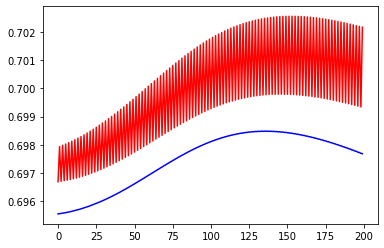

In [326]:
import matplotlib.pyplot as plt
plt.plot(list(range(step_range)),training_loss_value_list,c='blue')
plt.plot(list(range(step_range)),testing_loss_value_list,c='red')
plt.show()

#2. Plot the accuracy curve

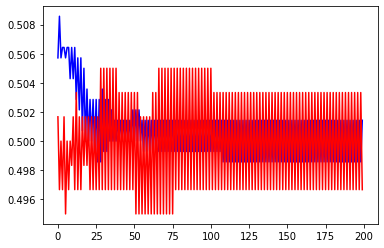

In [327]:
plt.plot(list(range(step_range)),training_accuracy_value_list,c='blue')
plt.plot(list(range(step_range)),testing_accuracy_value_list,c='red')
plt.show()

#3. Plot the quantitative results

In [323]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print(accuracy_score(y_train, y_pred_train))

print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test, y_pred_test))

NameError: ignored

#4. Testing accuracy

In [ ]:
print("The final testing accuracy is " + str(testing_accuracy_value_list[-1]*100)+" %")